<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Generalized Random Forest Module: Use Cases and Examples

Causal Forests and [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf) are a flexible method for estimating treatment effect heterogeneity with Random Forests. The `econml.grf` module implements a high-performance Cython version of the [`grf`](https://github.com/grf-labs/grf) R-package, with support for CausalForests, IVForests and RegressionForests. The module provides estimators that adhere to the scikit-learn fit and predict API, as well as providing methods for uncertainty quantification and confidence intervals.

Within the EconML SDK we use these estimators as final models for CATE estimation, such as in the case of `econml.dml.CausalForestDML`, where we combine a Causal Forest with Double Machine Learning, to residualize the treatment and outcome and call the `econml.grf.CausalForest` on the residuals. Similarly, the `econml.dr.ForestDRLearner` uses an `econml.grf.RegressionForest` as a final stage estimator on the doubly robust targets estimated by the first stage. The estimators here should primarily be used in conjunction with CateEstimators and not as standalone, but we provide here examples of their direct usage functionality.

The EconML SDK implements the following Generalized Random Forest variants:

* `CausalForest`: suitable for many continuous or discrete treatments, when there is no unobserved confounding

* `CausalIVForest`: suitable for many continuous or discrete treatments, when there is unobserved confounding and access to an instrument

* `RegressionForest`: an analogue of `sklearn.ensemble.RandomForestRegressor`, but with support for confidence intervals.

If you also have multiple outcomes, then the class `econml.grf.MultiOutputGRF`, is a wrapper class that wraps any generalized random forest and enables support for multiple outcomes by fitting a separate forest for each target outcome.

Our estimators provide support for the heterogeneity criterion as outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf), using `criterion='het'`, as well as a mean squared error criterion that penalizes high-variance splits, using `criterion='mse'`.[Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

Uncertainty quantification and confidence intervals is computed via the Bootstrap-of-Little-Bags approach outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

The tree data structure that is used to store each tree is compatible with `sklearn.tree._tree.Tree` and so scikit-learn functionalities on trees can be applied to our trained trees (e.g. tree plotting).


## Notebook Contents

1. [Causal Forest: Heterogeneous causal effects with no unobserved confounders](#1.-Causal-Forest:-Heterogeneous-causal-effects-with-no-unobserved-confounders)
2. [Causal IV Forest: Heterogeneous causal effects with unobserved confounders](#2.-Causal-IV-Forest:-Heterogeneous-causal-effects-with-unobserved-confounders)
3. [Regression Forest: Random Forest Regressor with confidence intervals](#3.-Regression-Forest:-Random-Forest-Regressor-with-confidence-intervals)
4. [Combining with Double Machine Learning](#4.-Combining-with-Double-Machine-Learning)
6. [Customer Linear Moment Forest](#5.-Custom-Linear-Moment-Forest)

In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

## 1. Causal Forest: Heterogeneous causal effects with no unobserved confounders

In [2]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + np.random.normal(0, .5, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [3]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [4]:
est.fit(X, T, y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

In [5]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

In [6]:
point = est.predict(X_test)

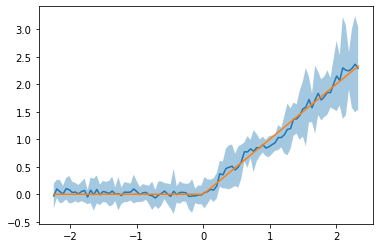

In [7]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

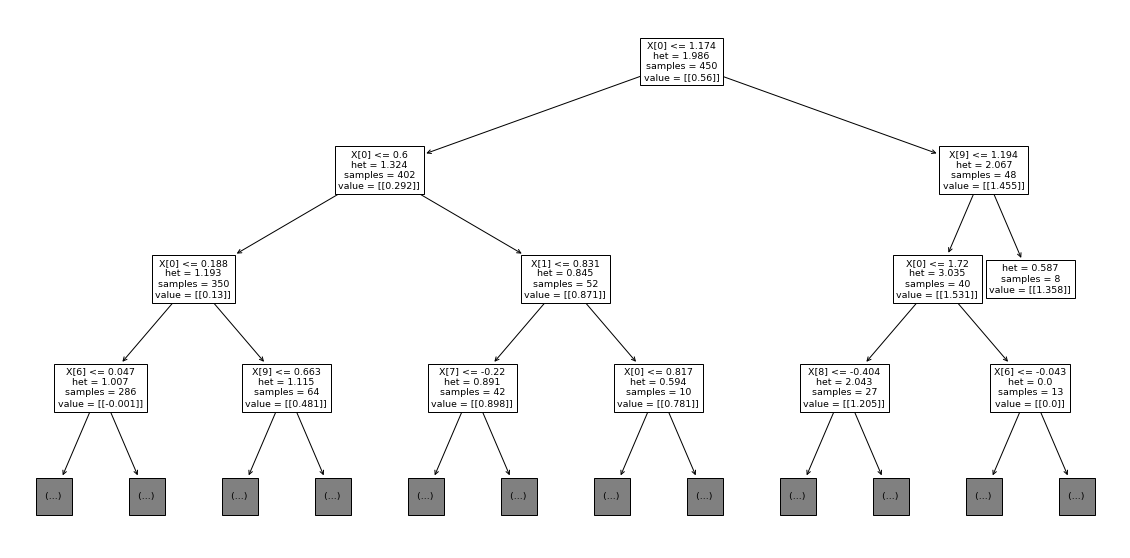

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=3)
plt.show()

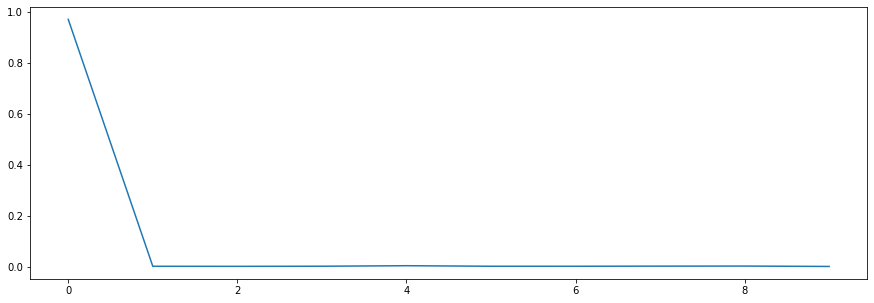

In [9]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

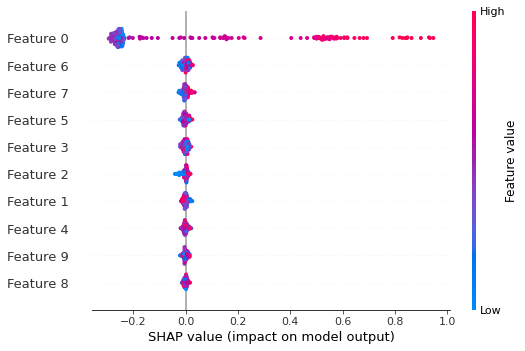

In [10]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])
shap.plots.beeswarm(shap_values)

In [11]:
est.decision_path(X_test[:1])

(<1x47712 sparse matrix of type '<class 'numpy.int64'>'
 	with 3902 stored elements in Compressed Sparse Row format>,
 array([    0,   119,   234,   355,   476,   597,   712,   837,   956,
         1079,  1198,  1321,  1440,  1565,  1686,  1809,  1930,  2055,
         2166,  2283,  2404,  2519,  2638,  2759,  2880,  3001,  3120,
         3237,  3358,  3477,  3600,  3719,  3840,  3965,  4076,  4201,
         4314,  4435,  4562,  4691,  4808,  4931,  5054,  5169,  5288,
         5409,  5524,  5643,  5756,  5877,  5992,  6115,  6238,  6357,
         6474,  6593,  6706,  6825,  6942,  7063,  7182,  7299,  7412,
         7523,  7644,  7763,  7890,  8013,  8136,  8255,  8370,  8485,
         8606,  8733,  8856,  8979,  9102,  9221,  9334,  9453,  9578,
         9697,  9820,  9939, 10056, 10173, 10282, 10395, 10516, 10633,
        10752, 10877, 11004, 11119, 11246, 11367, 11484, 11597, 11716,
        11837, 11954, 12075, 12186, 12305, 12430, 12545, 12668, 12791,
        12910, 13029, 13146, 1

In [12]:
est.apply(X_test[:1])

array([[31, 24, 47, 17, 15, 61, 13, 34, 53, 29, 21, 54, 23, 44,  8,  9,
         8, 52, 12,  6, 12, 16, 53, 68, 46, 29, 13, 15, 11, 30, 15, 19,
        36, 58, 20,  9, 52, 80, 33, 75, 46, 14, 19, 37, 64, 32, 58, 29,
        65, 42, 66, 21,  8, 68, 26, 23, 32, 23, 73, 51, 39, 21, 16,  9,
        12, 74, 20, 39, 13, 20, 37, 16,  8,  6, 74, 18, 24, 26, 50, 26,
        30, 23, 64, 34, 18, 73, 34, 45, 51, 50, 15, 31, 56, 20, 89, 55,
         8, 72, 24, 28, 14, 60, 72, 30, 27, 37, 22, 22,  6, 56,  7, 69,
        28, 67, 43,  6, 54, 32,  9, 36, 10, 19, 28, 12, 91, 10, 36, 88,
        13, 27, 24, 46, 11, 29, 17, 46, 27, 54, 17,  9, 45, 10, 12, 58,
        37,  6, 65, 16, 71, 26, 66,  7,  8,  6, 32, 18, 12, 45, 27, 17,
        19, 34, 68, 68, 40, 28, 33, 23, 83, 12,  7, 46, 28, 23, 82, 54,
        11, 44, 20, 36, 29, 47, 26,  9, 10, 49, 40, 54,  8, 45, 24, 43,
        10,  6, 36, 15, 29, 33, 73,  9, 51, 27, 27, 45, 41, 42, 41, 46,
        12, 12, 22, 13, 53,  9, 50, 11, 47,  7, 44, 12,  9, 69, 

## 2. Causal IV Forest: Heterogeneous causal effects with unobserved confounders

In [13]:
np.random.seed(1227)
n_samples = 2000
n_features = 10
n_treatments = 2
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [14]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [15]:
est.fit(X, T, y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [16]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

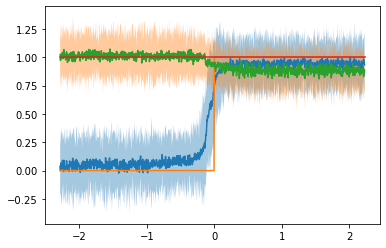

In [17]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

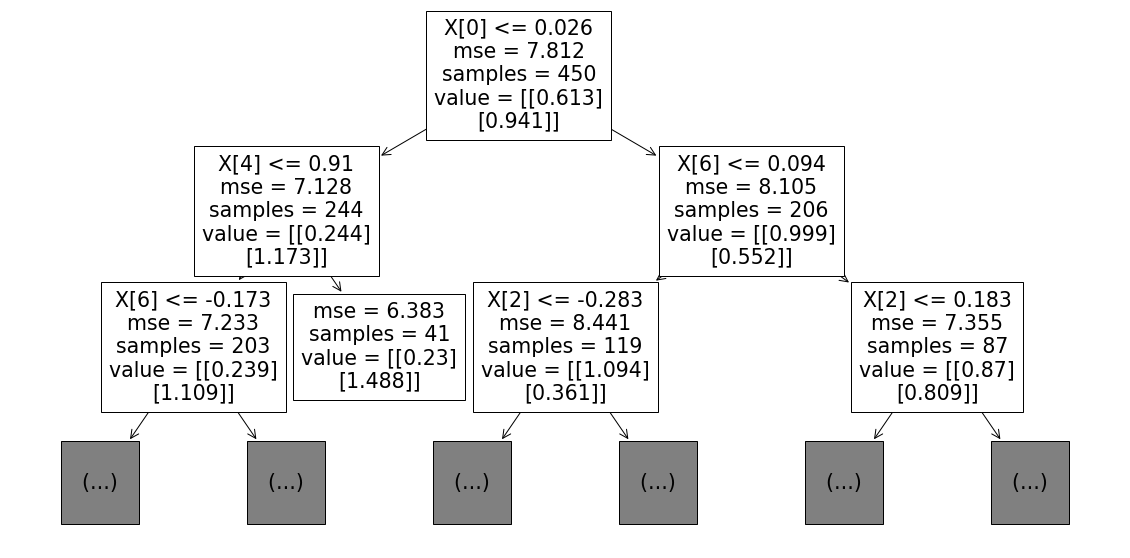

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

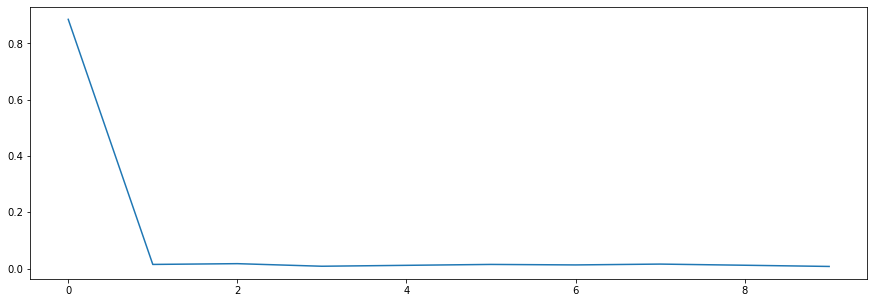

In [19]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [20]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

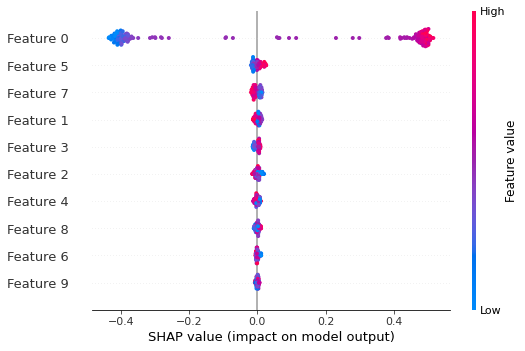

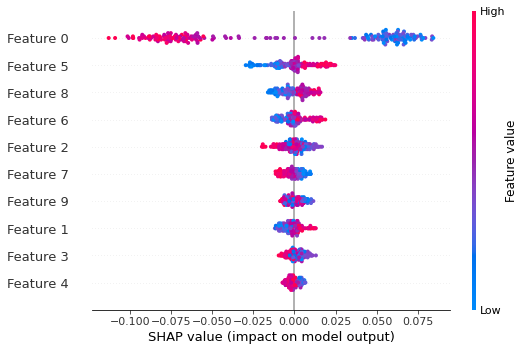

In [21]:
shap.plots.beeswarm(shap_values[:, :, 0])
shap.plots.beeswarm(shap_values[:, :, 1])

In [22]:
est[0].decision_path(X_test[:1])

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [23]:
est[0].apply(X_test[:1])

array([3], dtype=int64)

## 3. Regression Forest: Random Forest Regressor with confidence intervals

In [24]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [25]:
est = RegressionForest(n_estimators=400, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [26]:
est.fit(X, y)

RegressionForest(n_estimators=400, random_state=1235)

In [27]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

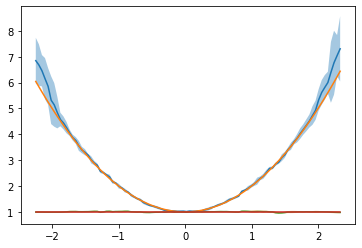

In [28]:
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

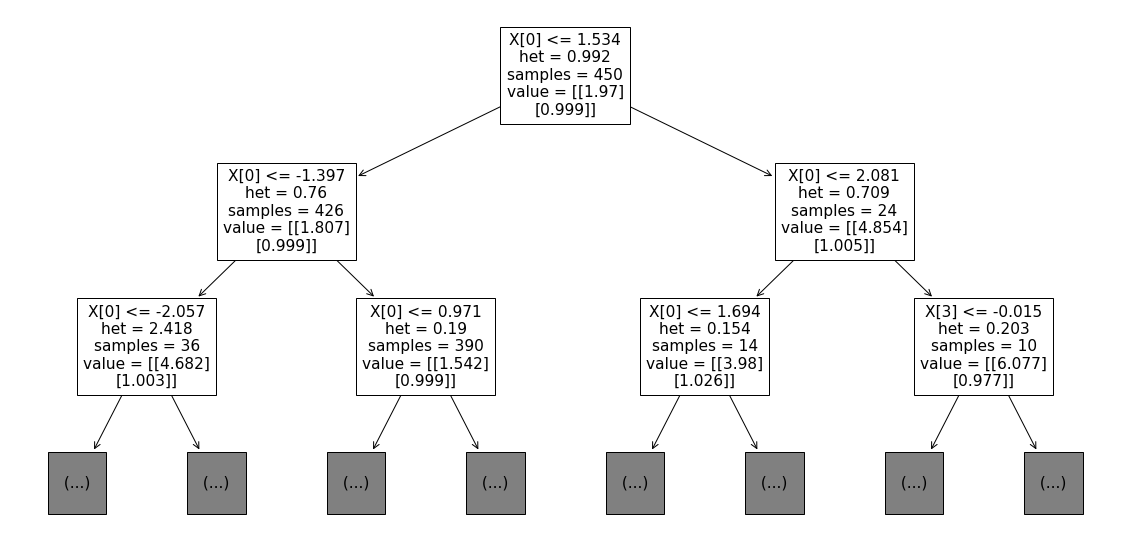

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

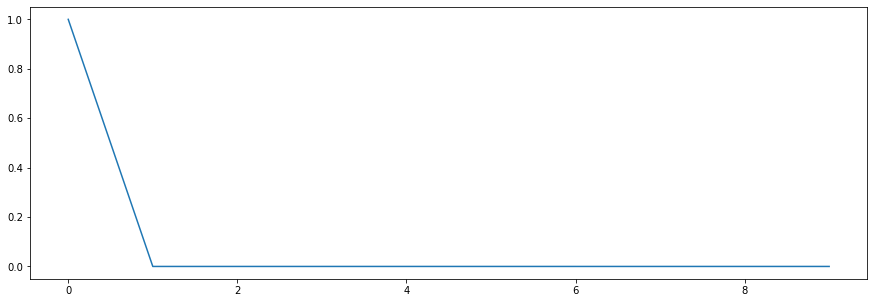

In [30]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [31]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

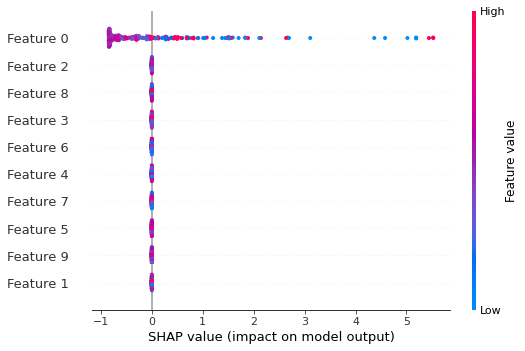

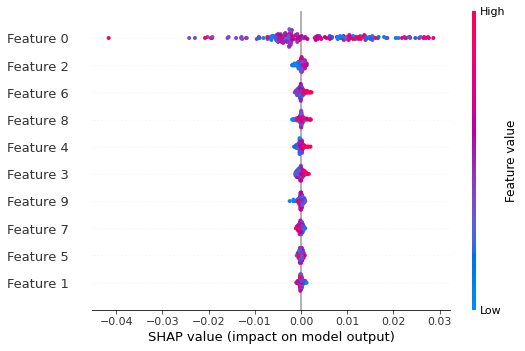

In [32]:
shap.plots.beeswarm(shap_values[:, :, 0])
shap.plots.beeswarm(shap_values[:, :, 1])

## 4. Combining with Double Machine Learning

In [33]:
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 3
n_outputs = 2
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [34]:
est = CausalForestDML(cv=2,
                      criterion='mse', n_estimators=400,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123)
%time est.fit(y, T, X=X, W=W)

Wall time: 11.3 s


In [35]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

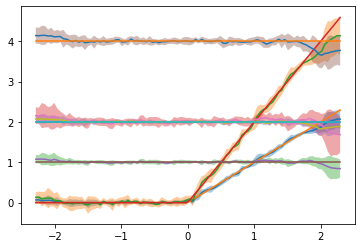

In [36]:
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point[:, j, t])
        plt.fill_between(X_test[:,0], lb[:, j, t], ub[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

In [37]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y  T                                                             
0  Y0 T0           0.066   0.025   2.660   0.008     0.025     0.107
      T1           1.077   0.040  26.652   0.000     1.011     1.144
      T2           2.071   0.039  53.520   0.000     2.007     2.134
   Y1 T0           0.132   0.050   2.660   0.008     0.050     0.213
      T1           2.155   0.081  26.652   0.000     2.022     2.288
...                  ...     ...     ...     ...       ...       ...
99 Y0 T1           0.842   0.087   9.706   0.000     0.699     0.985
      T2           1.887   0.074  25.641   0.000     1.766     2.008
   Y1 T0           4.139   0.187  22.148   0.000     3.832     4.447
      T1           1.684   0.174   9.706   0.000     1.399     1.970
      T2           3.774   0.147  25.641   0.000     3.532     4.016

[600 rows x 6 columns]

In [38]:
res = est.effect_inference(X_test,
                           T0=np.zeros((X_test.shape[0], n_treatments)),
                           T1=np.ones((X_test.shape[0], n_treatments)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

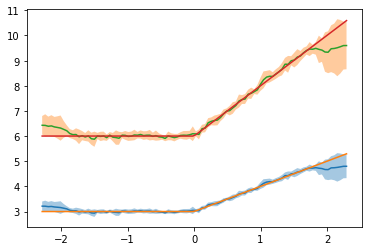

In [39]:
for j in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, j])
    plt.fill_between(X_test[:,0], lb[:, j], ub[:, j], alpha=.4)
    plt.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
plt.show()

In [40]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y                                                             
0  Y0           3.214   0.072  44.951     0.0     3.097     3.332
   Y1           6.428   0.143  44.951     0.0     6.193     6.663
1  Y0           3.212   0.086  37.447     0.0     3.071     3.353
   Y1           6.424   0.172  37.447     0.0     6.142     6.706
2  Y0           3.194   0.074  43.012     0.0     3.072     3.317
...               ...     ...     ...     ...       ...       ...
97 Y1           9.551   0.413  23.151     0.0     8.872    10.229
98 Y0           4.798   0.185  25.954     0.0     4.494     5.102
   Y1           9.596   0.370  25.954     0.0     8.988    10.204
99 Y0           4.799   0.183  26.212     0.0     4.497     5.100
   Y1           9.597   0.366  26.212     0.0     8.995    10.199

[200 rows x 6 columns]

In [41]:
est.feature_importances_

array([[0.98217628, 0.00347145, 0.00153771, 0.00260605, 0.00102379,
        0.00138967, 0.00223861, 0.00133064, 0.0030675 , 0.00115831],
       [0.98217628, 0.00347145, 0.00153771, 0.00260605, 0.00102379,
        0.00138967, 0.00223861, 0.00133064, 0.0030675 , 0.00115831]])

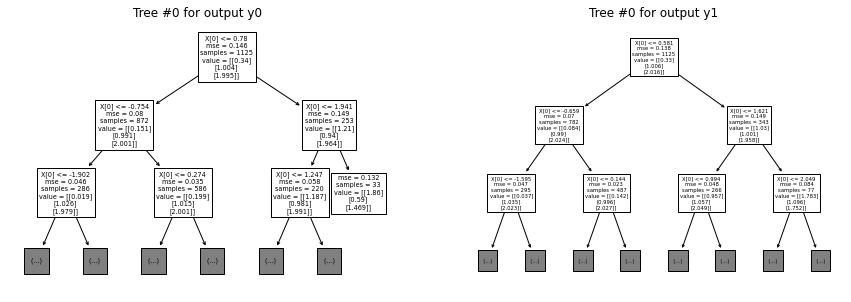

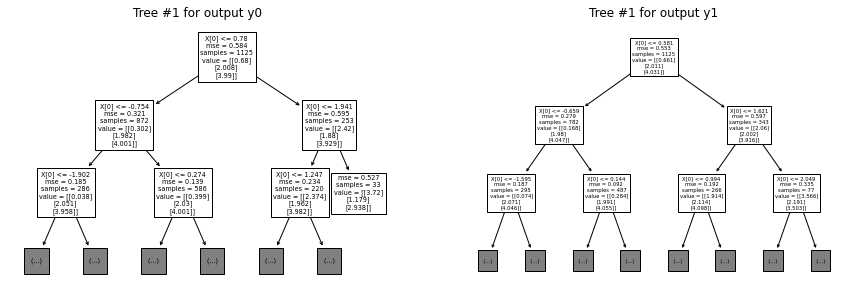

In [42]:
for tree_id, tree_per_output in enumerate(est[:2]):
    plt.figure(figsize=(15, 5))
    for j in range(n_outputs):
        plt.subplot(1, n_outputs, j + 1)
        plot_tree(tree_per_output[j], max_depth=2)
        plt.title("Tree #{} for output y{}".format(tree_id, j))
    plt.show()

In [43]:
est[0]

[GRFTree(max_features='auto', min_var_leaf=0.020617404788809485,
         min_var_leaf_on_val=True, random_state=914636141),
 GRFTree(max_features='auto', min_var_leaf=0.020617404788809485,
         min_var_leaf_on_val=True, random_state=914636141)]

In [44]:
import shap
shap_values = est.shap_values(X[:20])

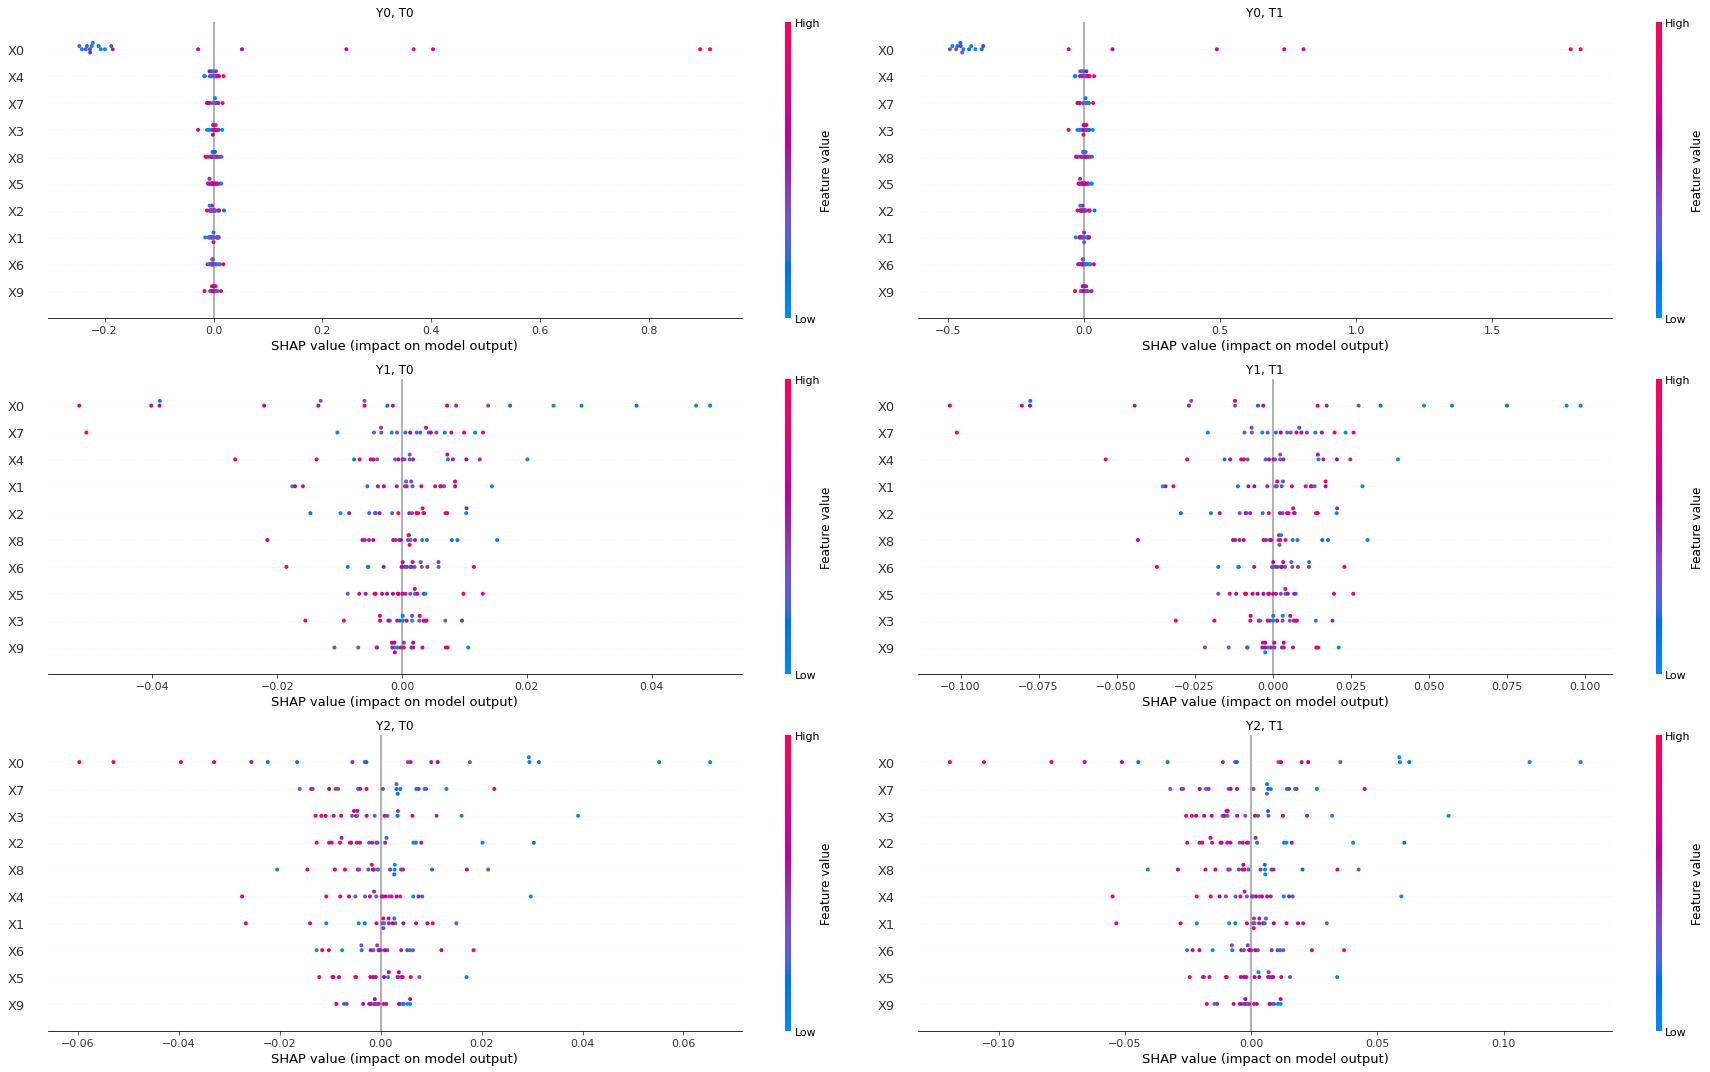

In [45]:
plt.figure(figsize=(25, 15))
for j in range(n_treatments):
    for i in range(n_outputs):
        plt.subplot(n_treatments, n_outputs, i + j * n_outputs + 1)
        plt.title("Y{}, T{}".format(j, i))
        shap.plots.beeswarm(shap_values['Y' + str(i)]['T' + str(j)], plot_size=None, show=False)
plt.tight_layout()
plt.show()

# 5. Custom Linear Moment Forest

We can even easily create an estimator class that solves a customer linear moment that we want to define on the fly. The `BaseGRF` class can handle the estimation of any linear moment problem of the form:
\begin{equation}
E[\text{pointJ} \cdot (\theta(x); \beta(x)) - \alpha \mid X=x] = 0
\end{equation}

The user simply needs to create a child class that inherits from the `BaseGRF` and implement the abstract methods `_get_alpha_and_pointJ` and `_get_n_outputs_decomposition`. The first function takes as input all the variables passed at fit time (i.e. `X`, `T`, `y`, and any other keyword based variables the user passes) and returns for each sample the $\alpha$ vector of the linear moment and a flattened version of the $\text{pointJ}$ matrix in the linear moment (in Fortran contiguous form, i.e. the first row is first, the second row next etc). The second function returns two numbers, the first number corresponds to the size of the concatenated parameter vector $(\theta(x); \beta(x))$ and the second number corresponds to the size of the prefix $\theta(x)$ that we care about ($\beta(x)$ is a nuisance parameter).

As a simple expository example let's see how we can create a forest that solves a moment of the form:
\begin{equation}
E[(y - \theta(x)' (T; T^2)) (Z; Z^2) \mid X=x]
\end{equation}
i.e. where we expand the treatments and instruments to include their squares and solve this quadratic in treatment heterogenous IV model.

In [46]:
np.random.seed(1227)
n_samples = 2000
n_features = 10
n_treatments = 2
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [47]:
from econml.grf._base_grf import BaseGRF
from econml.utilities import cross_product

class CustomGRF(BaseGRF):
    
    def _get_alpha_and_pointJ(self, X, T, y, *, Z):
        T = np.hstack([T, T**2])
        Z = np.hstack([Z, Z**2])
        if self.fit_intercept:
            T = np.hstack([T, np.ones((T.shape[0], 1))])
            Z = np.hstack([Z, np.ones((T.shape[0], 1))])
        return y * Z, cross_product(Z, T)
            
    
    def _get_n_outputs_decomposition(self, X, T, y, *, Z):
        n_relevant_outputs = T.shape[1] * 2
        n_outputs = n_relevant_outputs
        if self.fit_intercept:
            n_outputs += 1
        return n_outputs, n_relevant_outputs

In [48]:
est = CustomGRF(criterion='mse', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [49]:
est.fit(X, T, y, Z=Z)

CustomGRF(min_impurity_decrease=0.001, min_samples_leaf=40,
          min_var_fraction_leaf=0.1, min_var_leaf_on_val=True, n_estimators=400,
          random_state=123)

In [50]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

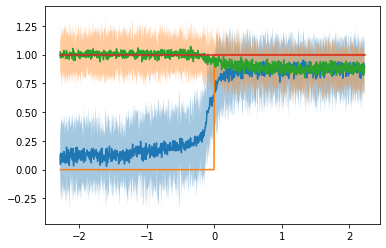

In [51]:
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

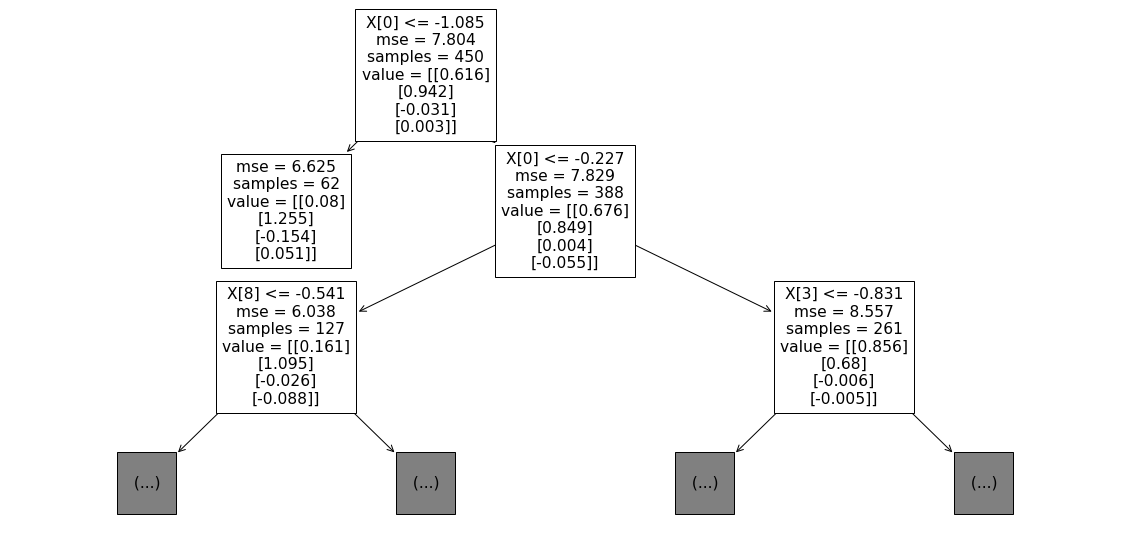

In [52]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

In [53]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

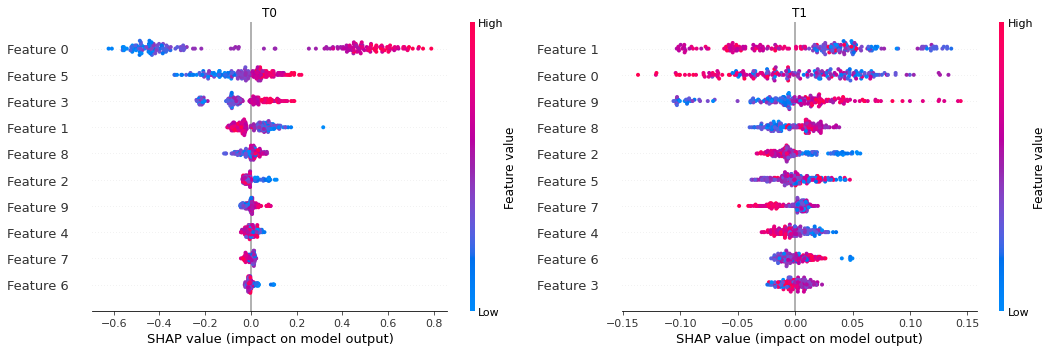

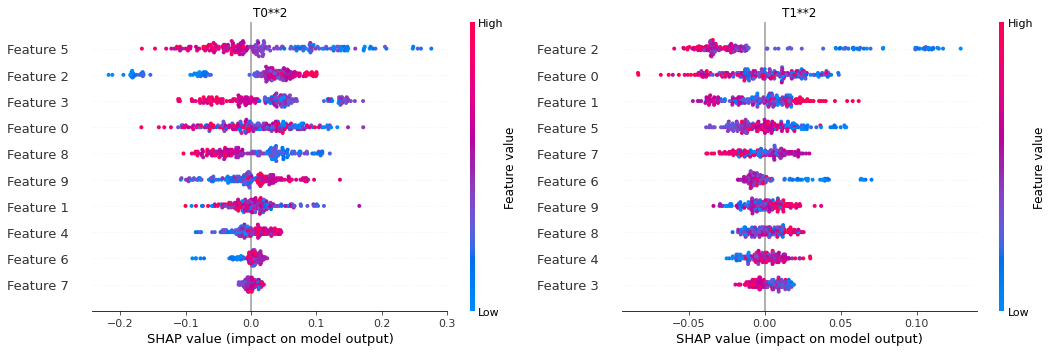

In [54]:
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title("T{}".format(t))
    shap.plots.beeswarm(shap_values[..., t], plot_size=None, show=False)
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title("T{}**2".format(t))
    shap.plots.beeswarm(shap_values[..., t + n_treatments], plot_size=None, show=False)
plt.tight_layout()
plt.show()